## Tutorial : Running minimal inference examples with diffuser.

For this tutorial, we will use my pre-trained lora embedding that is pretrained on pop-arts, illustrations and pixar footages.

To get started install this package with:

```bash
pip install git+https://github.com/cloneofsimo/lora.git
```


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

/home/simo/anaconda3/envs/pytorch_latest/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


  0%|          | 0/51 [00:00<?, ?it/s]

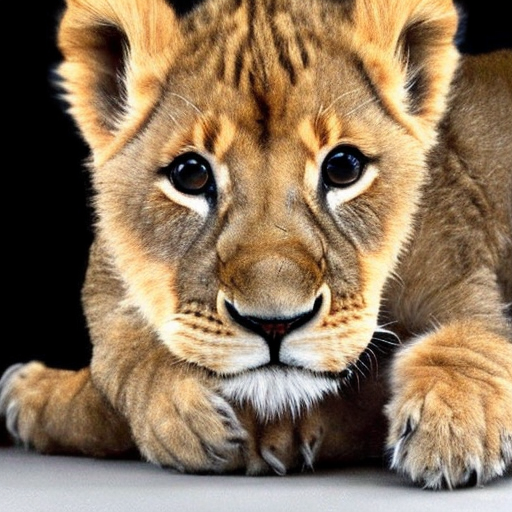

In [1]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "stabilityai/stable-diffusion-2-1-base"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    "cuda"
)

prompt = "style of sks, baby lion"
torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]

image  # nice. diffusers are cool.


Now there is two way to LORA this model. You can 1. monkey-patch it, or 2. update the weight inplaced.

Monkey-patching is essentially replacing the linear layer with a lora-linear layer, which is the following

$$
x_2 = Wx_1 + A B^T x_1
$$

On the other hand, weight updating is literally replacing the original weight with the LORA weight. This is the following

$$
W' = W + A B^T
$$

You might find this weird. Just having the weight updated is the logical option. Why even monkey-patch when you can add the weights? Well, by keeping the LORA weights we can perform _weight mixing_ dynamically. We can't do this if we just update the weight, because the weight is fixed. This is the reason why we have two options. You can adjust the weight with `tune_lora_scale` function.


  0%|          | 0/51 [00:00<?, ?it/s]

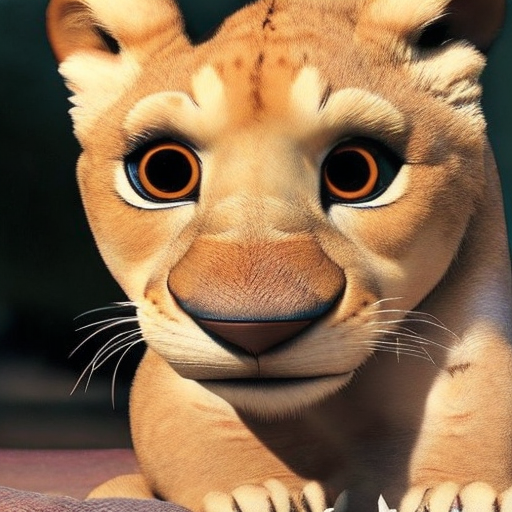

In [2]:
from lora_diffusion import monkeypatch_lora, tune_lora_scale


monkeypatch_lora(pipe.unet, torch.load("../lora_disney.pt"))

tune_lora_scale(pipe.unet, 1.00)

torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]
image


  0%|          | 0/51 [00:00<?, ?it/s]

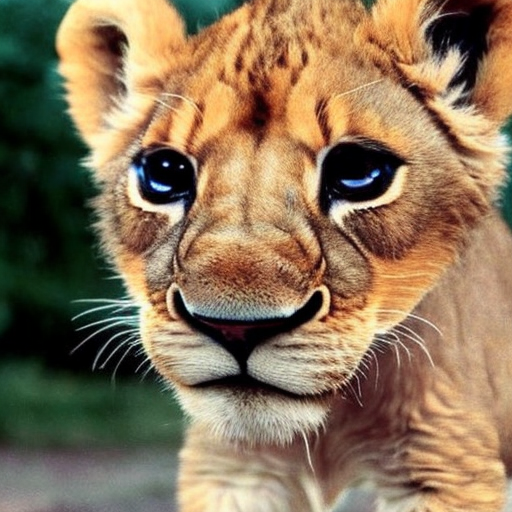

In [3]:
torch.manual_seed(0)

tune_lora_scale(pipe.unet, 0.5)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]
image


Nice. Let's try another example:


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

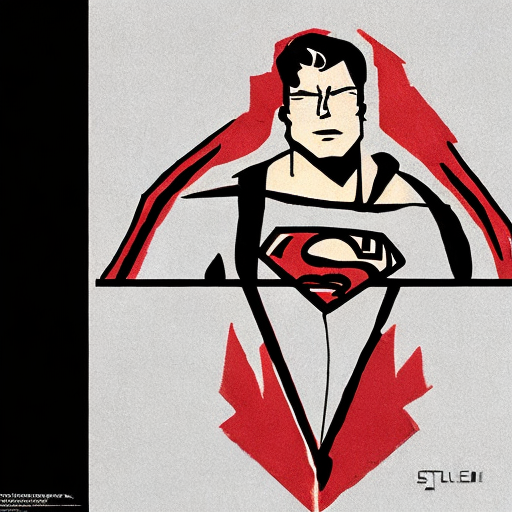

In [13]:
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    "cuda"
)

prompt = "style of sks, superman"
torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]

image


  0%|          | 0/51 [00:00<?, ?it/s]

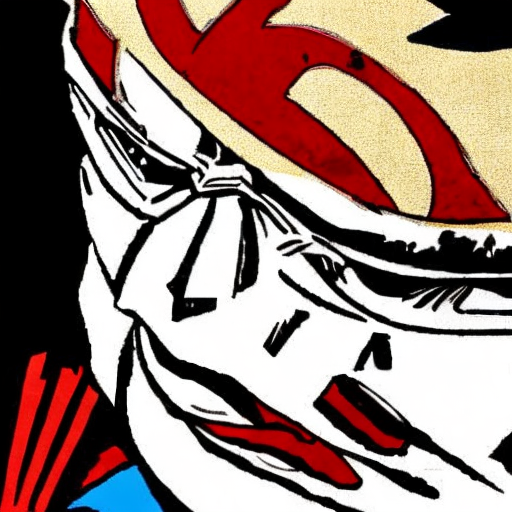

In [14]:
monkeypatch_lora(pipe.unet, torch.load("../lora_pop.pt"))
torch.manual_seed(0)
tune_lora_scale(pipe.unet, 1.00)
# apply_lora(pipe.unet)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]
image


Ouch, that must have been overfitting. Let's try to lower the alpha to have less effect : This is the result of alpha = 0.7.


  0%|          | 0/51 [00:00<?, ?it/s]

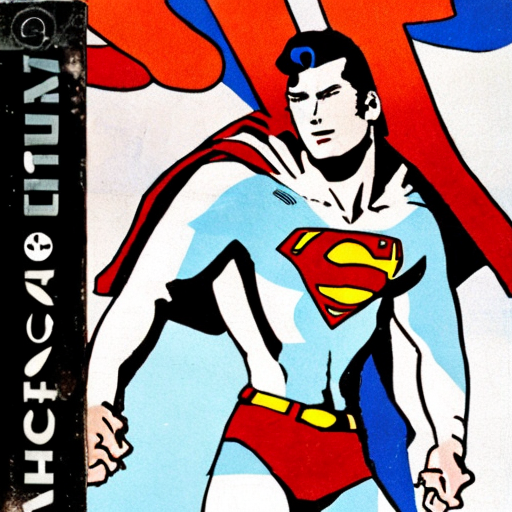

In [21]:
torch.manual_seed(0)
tune_lora_scale(pipe.unet, 0.7)

image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]
image


#
